# BLE Proximity Experiment - Random Forest Classifier
## Experiment based on the measurements of the BLE RSSI values according to the distance to the BLE Estimote beacon

### Imports
Imports of required libraries

In [3]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
import sklearn
import scipy

#Graphical Display
%matplotlib inline
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()
from pandas.plotting import scatter_matrix

plt.style.use('seaborn-whitegrid')

#Additional Helper Libraries
from operator import itemgetter
import re

<Figure size 432x288 with 0 Axes>

### Load File
Function that allows to load a file from disk

In [4]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

### Replace 0 with Nan RSSI Values

In [5]:
def replace_features_nan(dataset):
    dataset['rssi_Value'] = dataset['rssi_Value'].replace(0,np.nan)
    dataset['rolling_mean_rssi'] = dataset['rolling_mean_rssi'].replace(0,np.nan)

### Initialize Dataset
Initialization of the data from the file

In [6]:
dataset = load_file('../../distance_proximity_experiments.csv')
positions = dataset['coordinate_Y']
dataset['distance'] = positions
replace_features_nan(dataset)
display(dataset)
display(dataset.shape)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-47,-47.000000,0-1 meters,0.0
1,0.0,0.0,-46,-46.500000,0-1 meters,0.0
2,0.0,0.0,-46,-46.333333,0-1 meters,0.0
3,0.0,0.0,-47,-46.500000,0-1 meters,0.0
4,0.0,0.0,-47,-46.600000,0-1 meters,0.0
...,...,...,...,...,...,...
12470,0.0,3.5,-87,-84.555556,3-4 meters,3.5
12471,0.0,3.5,-87,-84.684211,3-4 meters,3.5
12472,0.0,3.5,-87,-84.800000,3-4 meters,3.5
12473,0.0,3.5,-87,-84.904762,3-4 meters,3.5


(12475, 6)

### Initialize Test Set

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-50,-50.000000,0-1 meters,0.0
1,0.0,0.0,-50,-50.000000,0-1 meters,0.0
2,0.0,0.0,-53,-51.000000,0-1 meters,0.0
3,0.0,0.0,-51,-51.000000,0-1 meters,0.0
4,0.0,0.0,-53,-53.000000,0-1 meters,0.0
...,...,...,...,...,...,...
410,0.0,3.5,-86,-83.800000,3-4 meters,3.5
411,0.0,3.5,-88,-84.500000,3-4 meters,3.5
412,0.0,3.5,-84,-84.428571,3-4 meters,3.5
413,0.0,3.5,-83,-84.250000,3-4 meters,3.5


(415, 6)

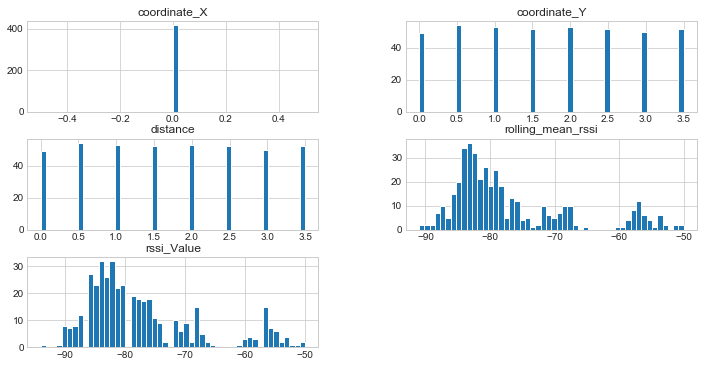

In [7]:
test_dataset = load_file('../../distance_proximity_experiments-checkpoint.csv')
positions = test_dataset['coordinate_Y']
test_dataset['distance'] = positions
replace_features_nan(test_dataset)
display(test_dataset)
display(test_dataset.shape)
test_dataset.hist(bins=50,figsize=(12,6))
plt.show()

### Initialize Test Set (My Device)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-44,-44.000000,0-1 meters,0.0
1,0.0,0.0,-44,-44.000000,0-1 meters,0.0
2,0.0,0.0,-44,-44.000000,0-1 meters,0.0
3,0.0,0.0,-44,-44.000000,0-1 meters,0.0
4,0.0,0.0,-45,-44.200000,0-1 meters,0.0
...,...,...,...,...,...,...
2279,0.0,3.5,-84,-83.944444,3-4 meters,3.5
2280,0.0,3.5,-85,-84.000000,3-4 meters,3.5
2281,0.0,3.5,-85,-84.050000,3-4 meters,3.5
2282,0.0,3.5,-92,-84.428571,3-4 meters,3.5


(2284, 6)

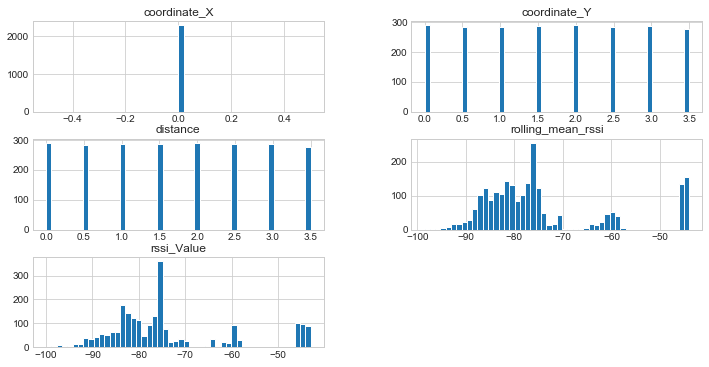

In [8]:
test_dataset_my_device = load_file('../../dataset_test.csv')
positions = test_dataset_my_device['coordinate_Y']
test_dataset_my_device['distance'] = positions
replace_features_nan(test_dataset_my_device)
display(test_dataset_my_device)
display(test_dataset_my_device.shape)
test_dataset_my_device.hist(bins=50,figsize=(12,6))
plt.show()

### Dataset Overall Info

In [9]:
display(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12475 entries, 0 to 12474
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   coordinate_X       12475 non-null  float64
 1   coordinate_Y       12475 non-null  float64
 2   rssi_Value         12475 non-null  int64  
 3   rolling_mean_rssi  12475 non-null  float64
 4   zone               12475 non-null  object 
 5   distance           12475 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 584.9+ KB


None

### File Overall Description
Usage of describe pandas function on the dataset

In [10]:
display(dataset.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
coordinate_X,12475.0,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0
coordinate_Y,12475.0,1.728457,1.144743,0.0,0.5,1.500000,2.50,3.5
rssi_Value,12475.0,-73.416754,12.929039,-102.0,-82.0,-76.000000,-64.00,-45.0
rolling_mean_rssi,12475.0,-73.454044,12.766312,-98.5,-82.2,-76.285714,-63.75,-46.0
distance,12475.0,1.728457,1.144743,0.0,0.5,1.500000,2.50,3.5


### % of Missing Values

In [11]:
def compute_missing_values(dataset): 
    missing_values = dataset.isnull().sum()
    missing_values_dataset = pd.DataFrame(missing_values,columns=['Missing Values'])
    missing_percentage = (dataset.isnull().sum() / dataset.count()) * 100
    missing_percentage_dataset = pd.DataFrame(missing_percentage,columns=['% of Missing Values'])
    missing_dataset = missing_values_dataset.join(missing_percentage_dataset)
    display(missing_dataset)

In [12]:
compute_missing_values(dataset)

,Missing Values,% of Missing Values
coordinate_X,0,0.0
coordinate_Y,0,0.0
rssi_Value,0,0.0
rolling_mean_rssi,0,0.0
zone,0,0.0
distance,0,0.0


### Overall Histogram of dataset atributes

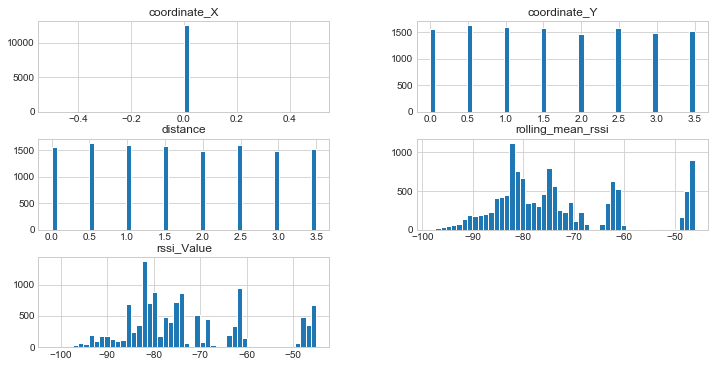

In [13]:
dataset.hist(bins=50,figsize=(12,6))
plt.show()

### Target Attribute - Zone
Graphical display of the zones scanned in the experiment

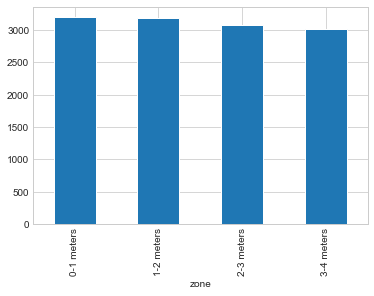

In [14]:
reference_points = dataset.groupby(['zone'])
reference_points.size().plot(kind="bar")

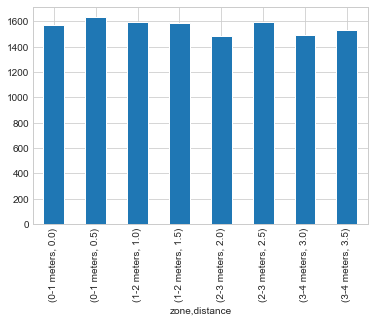

In [15]:
reference_points = dataset.groupby(['zone','distance'])
reference_points.size().plot(kind="bar")

### Beacon RSSI Display
Graphical display of the rssi values recorded at each position

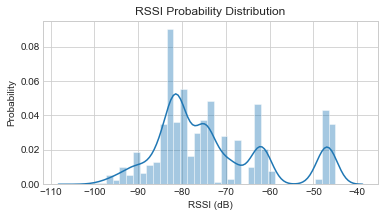

In [16]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')

sns.distplot(dataset['rssi_Value'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Beacon Rolling Mean RSSI Display
Graphical adisplay of the rolling mean value recorded at each position

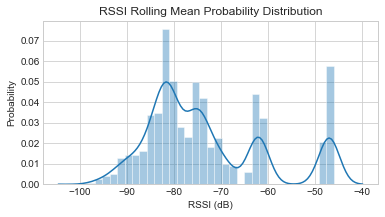

In [17]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Rolling Mean Probability Distribution')
# The KDE plot for the Rolling Mean column
sns.distplot(dataset['rolling_mean_rssi'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Graphical Display of RSSI/Rolling Mean Distribution
Graphical display of the previous measures - rssi and rolling mean

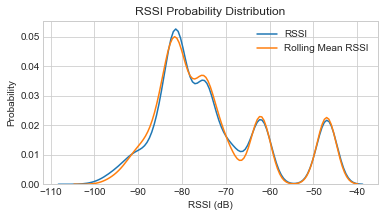

In [18]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')
# The KDE plot for the RSSI column
sns.kdeplot(dataset['rssi_Value'], label='RSSI')
# The KDE plot for the Rolling Mean column
sns.kdeplot(dataset['rolling_mean_rssi'], label='Rolling Mean RSSI')
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Correlations
Check how much each attribute collerates with each other. Valures frange from -1 to 1. Close to 1 means a strong positive correlation.

In [19]:
def compute_correlations(dataset):
    corr_matrix = dataset.corr()
    display(corr_matrix)
    display(corr_matrix['distance'].sort_values(ascending=False))
    attributes = ["distance","rssi_Value", "rolling_mean_rssi"]
    scatter_matrix(dataset[attributes], figsize=(12, 8))

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,distance
coordinate_X,NaN,NaN,NaN,NaN,NaN
coordinate_Y,NaN,1.000000,-0.864615,-0.873980,1.000000
rssi_Value,NaN,-0.864615,1.000000,0.981441,-0.864615
rolling_mean_rssi,NaN,-0.873980,0.981441,1.000000,-0.873980
distance,NaN,1.000000,-0.864615,-0.873980,1.000000


distance             1.000000
coordinate_Y         1.000000
rssi_Value          -0.864615
rolling_mean_rssi   -0.873980
coordinate_X              NaN
Name: distance, dtype: float64

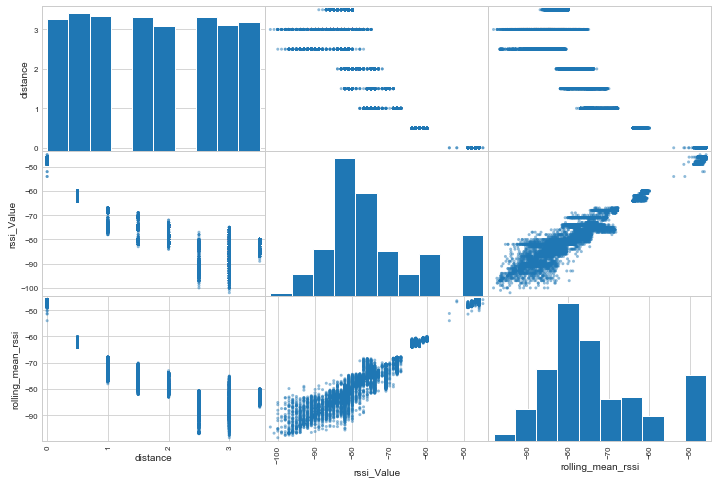

In [20]:
compute_correlations(dataset)

### Data Cleaning
Fill in missing values and fix/remove outliers

In [21]:
def compute_data_cleaning(dataset,feature):
    nan_filler = dataset[feature].min()*1.010
    dataset[feature] = dataset[feature].fillna(nan_filler) # Fill missing values

In [22]:
compute_data_cleaning(dataset,'rssi_Value')
compute_data_cleaning(dataset,'rolling_mean_rssi')
compute_data_cleaning(test_dataset,'rssi_Value')
compute_data_cleaning(test_dataset,'rolling_mean_rssi')
compute_data_cleaning(test_dataset_my_device,'rssi_Value')
compute_data_cleaning(test_dataset_my_device,'rolling_mean_rssi')

### Dealing with Categorical Data
Using Hot-Encoder or Label Encoder to convert text/categorical data into numerical data. ML algorithms prefer it

In [23]:
label_encoder = LabelEncoder()
def compute_encoder(categorical_data,flag):
    if flag == 0:
        labels = label_encoder.fit_transform(categorical_data)
    else:
        labels = label_encoder.transform(categorical_data)
    return labels

In [24]:
categorical_zone = dataset[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
zone_changed = compute_encoder(categorical_zone,0)
print("After One Hot Encoder")
dataset['labels'] = zone_changed
train_Y = dataset['labels'].values.reshape(-1,1)
display(train_Y)

Previous Categorical Data


,zone
0,0-1 meters
1,0-1 meters
2,0-1 meters
3,0-1 meters
4,0-1 meters
...,...
12470,3-4 meters
12471,3-4 meters
12472,3-4 meters
12473,3-4 meters


NameError: name 'commpute_encoder' is not defined

### Initialize Training Data
Training Data intialization for predictions purposes

In [ ]:
train_X_rssi = pd.DataFrame(dataset['rssi_Value']).values.reshape(-1,1)
train_X_rolling_mean = pd.DataFrame(dataset['rolling_mean_rssi']).values.reshape(-1,1)
train_Y = pd.DataFrame(dataset['zone']).values.reshape(-1,1)
combination_features_X = dataset[['rssi_Value','rolling_mean_rssi']]
default_groups = dataset['zone'].map(str)
data_plot_means = dataset.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

### Initialize Hyperparameters for tunning

In [ ]:
#Preprocessing options
scaler = [StandardScaler(),MaxAbsScaler(),MinMaxScaler(),None]
# Number of trees in random forest
initial_linespace = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] 
n_estimators = [10,100] + initial_linespace
# Criterion to consider at every split
criterion_metric = ['gini','entropy']
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'rf__n_estimators': n_estimators,
               'rf__criterion': criterion_metric,
               'rf__max_features': max_features,
               'rf__max_depth': max_depth,
               'rf__min_samples_split': min_samples_split,
               'rf__min_samples_leaf': min_samples_leaf,
               'rf__bootstrap': bootstrap}
print(random_grid)

### Plot Training Data
Graphical Display of the observations in the dataset

In [ ]:
plt.figure(figsize=(14,5))
plt.scatter(dataset['zone'],dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(dataset['zone'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Statistics Output Format
Structure of the statistical output of each call to the machine learning algorithm

In [ ]:
def structure_data(data,precision,accuracy,f1score):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    precision = precision
    accuracy = accuracy
    f1score = f1score
    statistical_results = [mae,mse,rsme,precision,accuracy,f1score]
    return statistical_results

### Random Forest Classifier Experiments
Experiments with RF algorithm

In [ ]:
def compute_RF_Classification(flag=0,colors=None,
                              trainX_data = None,fold=None, trainY_data = None,
                              testX_data = None,testY_data = None, 
                              scaler = None,cross_validation = None,
                              n_estimators_parameter = 100, criterion_parameter = 'gini',
                              max_depth_parameter = None,min_samples_split_parameter = 2,
                              min_samples_leaf_parameter = 1,max_features_parameter = 'auto',
                              bootstrap_parameter = True, random_state_parameter = 6):
    random_forest_estimator = RandomForestClassifier(n_estimators=n_estimators_parameter,criterion=criterion_parameter,
                                                    max_features=max_features_parameter,max_depth=max_depth_parameter,
                                                    min_samples_leaf=min_samples_leaf_parameter,min_samples_split=min_samples_split_parameter,
                                                    bootstrap=bootstrap_parameter,random_state=random_state_parameter)
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler,random_forest_estimator)
    else:
        main_estimator = random_forest_estimator
    if cross_validation is None:
        # Fit the training data
        main_estimator.fit(trainX_data,trainY_data)
        # Predict the results of the testing data features
        predict_test = main_estimator.predict(testX_data)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    else:
        main_estimator.fit(testX_data,testY_data)
        predict_test = cross_val_predict(main_estimator,testX_data,testY_data,cv = cross_validation,groups=default_groups)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    statistical_array = list()
    statistics = pd.DataFrame(report).transpose()
    error_dataframe = pd.DataFrame({'Actual': testY_data.flatten(), 'Predicted':predict_test.flatten()})
    if flag == 1:
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
        plt.figure(figsize=(12,6))
        plt.scatter(dataset['zone'],dataset['rssi_Value'],label='RSSI Value',color='blue')
        plt.scatter(dataset['zone'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
        if colors is not None:
            plt.plot(predict_test, testX_data,'s',color=colors,label='RF Classification' + ' CV : ' +str(fold))
        else:
            plt.plot(predict_test, testX_data,'s',color='red',label='RF Classification')
        # Show and place the legent
        plt.legend(loc='upper right')
        plt.show()
    if flag == 2:
        print("Feature Selection Computation")
        display(random_forest_estimator.feature_importances_)
        feature_imp = pd.Series(random_forest_estimator.feature_importances_,index=trainX_data.columns).sort_values(ascending=False)
        display(feature_imp)
        # Creating a bar plot
        sns.barplot(x=feature_imp, y=feature_imp.index)
        # Add labels to your graph
        plt.xlabel('Feature Importance Score')
        plt.ylabel('Features')
        plt.title("Visualizing Important Features")
        plt.show()
    display('Number of Classes Predicted: ' + str(random_forest_estimator.n_classes_))
    display('Number of Features Used: ' + str(random_forest_estimator.n_features_))
    error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
    result = pd.DataFrame(train_Y,columns=["zone"]).join(error)
    return structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean())

#### Feature Selection & OverFitting Scenario

In [ ]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
result = compute_RF_Classification(flag=2,trainX_data=combination_features_X,trainY_data=train_Y.ravel(),
                                   testX_data=combination_features_X,testY_data=train_Y.ravel(),
                                   scaler=StandardScaler())
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

#### 1st Experiment - Check Overfitting scenario (Without Testing Data) Using RSSI
Use Random Forest to check the results on the training data alone

In [ ]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
result = compute_RF_Classification(flag=1,trainX_data=train_X_rssi,trainY_data=train_Y.ravel(),
                                   testX_data=train_X_rssi,testY_data=train_Y.ravel(),
                                   scaler=StandardScaler())
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

#### 2nd Experiment - Check Overfitting scenario (Without Testing Data) Using Rolling Mean
Use Random Forest to check the results on the training data alone

In [ ]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
result = compute_RF_Classification(flag=1,trainX_data=train_X_rolling_mean,trainY_data=train_Y.ravel(),
                                   testX_data=train_X_rolling_mean,testY_data=train_Y.ravel(),
                                   scaler=StandardScaler())
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

#### 3rd Experiment - Random Forest with StratifiedKFold (RSSI pure)
Experiment using cross validation approach of StratifiedKFold

In [ ]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
cross_validation_list = np.arange(2,6)
colors = ['red','blue','yellow','green']
counter = 0
results = list()
for cv in cross_validation_list:
    result = compute_RF_Classification(flag = 1,colors=colors[counter],fold=cv,testX_data=train_X_rssi,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = cv)  
    result.append(cv)
    results.append(result)
    counter = counter + 1
statistical_cols.append('folds')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['folds'],statistics['mae'])
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

#### 4th Experiment - Random Forest with StratifiedKFold (Rolling Mean)
Experiment using cross validation approach of StratifiedKFold

In [ ]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
cross_validation_list = np.arange(2,6)
colors = ['red','blue','yellow','green']
counter = 0
results = list()
for cv in cross_validation_list:
    result = compute_RF_Classification(flag = 1,colors=colors[counter],fold=cv,testX_data=train_X_rolling_mean,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = cv)  
    result.append(cv)
    results.append(result)
    counter = counter + 1
statistical_cols.append('folds')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['folds'],statistics['mae'])
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

#### Combination of Features - Stratified KFold Experiment

In [ ]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
cross_validation_list = np.arange(2,6)
colors = ['red','blue','yellow','green']
counter = 0
results = list()
for cv in cross_validation_list:
    result = compute_RF_Classification(flag = 1,colors=colors[counter],fold=cv,testX_data=combination_features_X,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = cv)  
    result.append(cv)
    results.append(result)
    counter = counter + 1
statistical_cols.append('folds')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['folds'],statistics['mae'])
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

#### 5th Experiment - Random Forest with HoldOut (RSSI pure)
Experiment using cross validation approach of HoldOut (Train test split)

In [ ]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
for size in test_sizes:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(train_X_rssi,train_Y.ravel(), test_size = size, random_state = 6,stratify=default_groups)
    result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    result.append(size)
    results.append(result)
statistical_cols.append('test_size')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.plot(statistics['test_size'],statistics['f1-score'])

#### 6th Experiment - Random Forest with HoldOut (Rolling Mean)
Experiment using cross validation approach of HoldOut (Train test split)

In [ ]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
for size in test_sizes:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(train_X_rolling_mean,train_Y.ravel(), test_size = size, random_state = 6,stratify=default_groups)
    result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    result.append(size)
    results.append(result)
statistical_cols.append('test_size')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.plot(statistics['test_size'],statistics['f1-score'])

#### Combination of Features - HoldOut Experiment

In [ ]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
for size in test_sizes:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(combination_features_X,train_Y.ravel(), test_size = size, random_state = 6,stratify=default_groups)
    result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    result.append(size)
    results.append(result)
statistical_cols.append('test_size')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.plot(statistics['test_size'],statistics['f1-score'])

#### 7th Experiment - Random Forest with LOGO (RSSI)
Experiment using cross validation approach of Leave One Group Out

In [ ]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
results = list()
cv = LeaveOneGroupOut()
splited = cv.split(train_X_rssi,train_Y.ravel(),groups=default_groups)
loo = compute_RF_Classification(testX_data=train_X_rssi,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
results.append(loo)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

#### 8th Experiment - Random Forest with LOGO (Rolling Mean)
Experiment using cross validation approach of Leave One Group Out

In [ ]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
results = list()
cv = LeaveOneGroupOut()
splited = cv.split(train_X_rolling_mean,train_Y.ravel(),groups=default_groups)
loo = compute_RF_Classification(testX_data=train_X_rolling_mean,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
results.append(loo)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

#### Combination of Features - LOGO Experiment

In [ ]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
results = list()
cv = LeaveOneGroupOut()
splited = cv.split(combination_features_X,train_Y.ravel(),groups=default_groups)
loo = compute_RF_Classification(testX_data=combination_features_X,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
results.append(loo)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

#### 9th Experiment - Best cross-validation technique
Best parameters found using RF

In [ ]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','method','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
    holdout = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    cv = LeaveOneGroupOut()
    splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
    loo = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
    loo.append('LOO')
    loo.append(scannedType)
    results.append(loo)
    holdout.append('HoldOut')
    holdout.append(scannedType)
    results.append(holdout)
    skfold = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = selected_fold)
    skfold.append('Stratified K-Fold')
    skfold.append(scannedType)
    results.append(skfold)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['method'],statistics['mae'],'o')
selected_method = statistics.sort_values(by=['mae'])['method'].head(1).values[0]
print("Selected cross validation method: ",selected_method)

#### 10th Experiment - Best preprocessing technique
Experiment with the different preprocessing techniques

In [ ]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','preprocessing','preprocessingFunc','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X
    for preprocess in scaler:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=preprocess,cross_validation = splited)  
        elif selected_method =='Stratified K-Fold':
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=preprocess,cross_validation = selected_fold)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=preprocess)
        if(preprocess is None):
            regex = 'None'
        else:
            regex = re.search('(\w+)\(',str(preprocess)).group(1)
        result.append(regex)
        result.append(preprocess)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['preprocessing'],statistics['mae'])
selected_preprocessing = statistics.sort_values(by=['mae'])['preprocessing'].head(1).values[0]
selected_preprocesssing_func = statistics.sort_values(by=['mae'])['preprocessingFunc'].head(1).values[0]
print("Selected Preprocessing: ",selected_preprocessing)

#### 11th Experiment - Running the RF function with the different number of decision trees

In [ ]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','n_estimator','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X
    for n in n_estimators:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                n_estimators_parameter=n)  
        elif selected_method =='Stratified K-Fold':
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                                 cross_validation = selected_fold,
                                 n_estimators_parameter=n)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(), n_estimators_parameter=n)
        result.append(n)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['n_estimator'],statistics['mae'])
selected_estimator_size = statistics.sort_values(by=['mae'])['n_estimator'].head(1).values[0]
print("Selected Estimator Size: ",selected_estimator_size)

#### 12th Experiment - Running the RF function with the different criterias

In [ ]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','criterion','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X
    for metric in criterion_metric:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                criterion_parameter=metric)  
        elif selected_method =='Stratified K-Fold':
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                                 cross_validation = selected_fold,
                                 criterion_parameter=metric)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(), criterion_parameter=metric)
        result.append(metric)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['criterion'],statistics['mae'])
selected_criterion = statistics.sort_values(by=['mae'])['criterion'].head(1).values[0]
print("Selected Criterion: ",selected_criterion)

#### 13th Experiment - Running the RF function with the different max_features 

In [ ]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','max_feature','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X
    for max_feature in max_features:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                max_features_parameter=max_feature)  
        elif selected_method =='Stratified K-Fold':
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                                 cross_validation = selected_fold,
                                 max_features_parameter=max_feature)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(), max_features_parameter=max_feature)
        result.append(max_feature)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['max_feature'],statistics['mae'])
selected_max_feature = statistics.sort_values(by=['mae'])['max_feature'].head(1).values[0]
print("Selected max_feature: ",selected_max_feature)

#### 14th Experiment - Running the RF function with the different max_depth metric

In [ ]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','max_depth','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X
    for depth in max_depth:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                max_depth_parameter=depth)  
        elif selected_method =='Stratified K-Fold':
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                                 cross_validation = selected_fold,
                                 max_depth_parameter=depth)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(), max_depth_parameter=depth)
        result.append(depth)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['max_depth'],statistics['mae'])
selected_max_depth = statistics.sort_values(by=['mae'])['max_depth'].head(1).values[0]
print("Selected max_depth: ",selected_max_depth)

#### 15th Experiment: Running the RF function with the different min_samples_split metric

In [ ]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','min_samples_split','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X
    for s in min_samples_split:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                min_samples_split_parameter=s)  
        elif selected_method =='Stratified K-Fold':
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                                 cross_validation = selected_fold,
                                 min_samples_split_parameter=s)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(), min_samples_split_parameter=s)
        result.append(s)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['min_samples_split'],statistics['mae'])
selected_min_samples_splith = statistics.sort_values(by=['mae'])['min_samples_split'].head(1).values[0]
print("Selected min_samples_split: ",selected_min_samples_splith)

#### 16th Experiment: Running the RF function with the different min_samples_leaf metric

In [ ]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','min_samples_leaf','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X
    for leaf in min_samples_leaf:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                min_samples_leaf_parameter=leaf)  
        elif selected_method =='Stratified K-Fold':
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                                 cross_validation = selected_fold,
                                 min_samples_leaf_parameter=leaf)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(), min_samples_leaf_parameter=leaf)
        result.append(leaf)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['min_samples_leaf'],statistics['mae'])
selected_min_samples_leaf = statistics.sort_values(by=['mae'])['min_samples_leaf'].head(1).values[0]
print("Selected min_samples_leaf: ",selected_min_samples_leaf)

### Run RandomSearchCV for parameter tunning

In [ ]:
results = []
pipe = Pipeline([('standardizer', StandardScaler()), ('rf', RandomForestClassifier())])
clf = RandomizedSearchCV(
   pipe, param_distributions = random_grid, n_iter = 100, cv=selected_fold,n_jobs=-1,verbose=1
)
clf.fit(train_X_rolling_mean,train_Y.ravel())
results.append(clf.best_params_)
gridcv_results = pd.DataFrame(results)
display(gridcv_results)

### Best Parameters
Display the best parameters tunned throughout the experiments

In [ ]:
conclusion_cols=['Cross_Validation','Number of Estimators','Max Features','Max Depth','Criterion','Min_Samples_Leaf','Min_Samples_Split','Preprocessing']
conclusion_list = [selected_method,selected_estimator_size,selected_max_feature,selected_max_depth,selected_criterion,
                   selected_min_samples_leaf,selected_min_samples_splith,selected_preprocessing]
conclusion_pd = pd.DataFrame([conclusion_list],columns= conclusion_cols)
display(conclusion_pd)

### Best Results
Compute RF with the best parameters tuned by RandomGridSearchCV and manually tuned

In [ ]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','run','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
final_Type = ''
for i in range(3):
    if i == 0: #Default Run
        final_Type = 'DEFAULT'
        criterion = 'gini'
        estimators = 100
        depth = None
        max_feat = 'auto'
        min_samples_split = 2
        min_samples_leaf = 1
    if i == 1:#Manually Tuned Run
        final_Type = 'MANUALLY TUNED'
        criterion = selected_criterion
        estimators = selected_estimator_size
        depth = selected_max_depth
        max_feat = selected_max_feature
        min_samples_split = selected_min_samples_splith
        min_samples_leaf = selected_min_samples_leaf
    if i == 2: #Grid Run
        final_Type = 'GRID TUNED'
        criterion = clf.best_params_['rf__criterion']
        estimators = clf.best_params_['rf__n_estimators']
        depth = clf.best_params_['rf__max_depth']
        max_feat = clf.best_params_['rf__max_features']
        min_samples_split = clf.best_params_['rf__min_samples_split']
        min_samples_leaf = clf.best_params_['rf__min_samples_leaf']
    for scannedType in types:
        if scannedType == 'RSSI Only':
            trainX_data = train_X_rssi
        elif scannedType == 'Rolling Mean RSSI':
            trainX_data = train_X_rolling_mean
        else:
            trainX_data = combination_features_X
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                n_estimators_parameter=estimators,criterion_parameter=criterion,
                                              max_depth_parameter=depth, max_features_parameter=max_feat,
                                              min_samples_leaf_parameter=min_samples_leaf,
                                              min_samples_split_parameter=min_samples_split)  
        elif selected_method =='Stratified K-Fold':
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                                 cross_validation = selected_fold,
                                n_estimators_parameter=estimators,criterion_parameter=criterion,
                                              max_depth_parameter=depth, max_features_parameter=max_feat,
                                              min_samples_leaf_parameter=min_samples_leaf,
                                              min_samples_split_parameter=min_samples_split) 
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(),n_estimators_parameter=estimators,criterion_parameter=criterion,
                                              max_depth_parameter=depth, max_features_parameter=max_feat,
                                              min_samples_leaf_parameter=min_samples_leaf,
                                              min_samples_split_parameter=min_samples_split) 
        result.append(final_Type)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending = False))
statistical_cols_csv = ['mae','mse','rmse']
statistical_cols_csv.append('Experimentation')
result_csv = result[0:3]
result_csv.append('RF Classification')
results_csv = [result_csv]
results_df = pd.DataFrame(columns=statistical_cols_csv,data=results_csv)
results_df.to_csv('../proximity_results.csv',mode='a',index=False,header=False)
dataset = load_file('../proximity_results.csv')
dataset = dataset.sort_values(by=['mae'])
dataset.to_csv('../proximity_results.csv',index=False)

### Best Results - Testing data being 1000 plot points
Experiment with testing data of 1000 plot points

In [ ]:
testX_data = np.linspace(dataset['rssi_Value'].min(), dataset['rssi_Value'].max(), 1000).reshape(-1,1)
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
svc_estimator = RandomForestClassifier()
main_estimator = make_pipeline(StandardScaler(),svc_estimator)
main_estimator.fit(train_X_rolling_mean,train_Y.ravel())
predict_test = main_estimator.predict(testX_data)
plt.show()
plt.figure(figsize=(18,10))
plt.scatter(dataset['zone'],dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(dataset['zone'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.plot(predict_test, testX_data,'s',color='red', label='SVM Classifier')
# Show and place the legent
plt.legend(loc='upper right')
plt.show()